# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

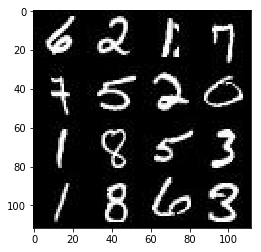

In [3]:
show_n_images = 24

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

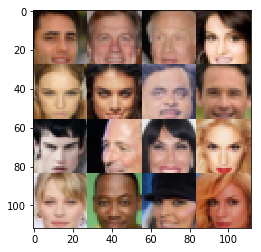

In [4]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, None, name='lr')

    return real, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/pedro/anaconda3/envs/tfgpu/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/pedro/anaconda3/envs/tfgpu/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/pedro/anaconda3/envs/tfgpu/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/pedro/anaconda3/envs/tfgpu/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/pedro/anaconda3/envs/tfgpu/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/pedro/an

### Custom helper functions 

In [7]:

def leaky_relu(x, alpha, name='leaky_relu'):
    return tf.maximum(x * alpha, x, name=name)

def smooth_labels(logits, smooth=0.1):
    return tf.ones_like(logits) * (1 - smooth)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [38]:
def discriminator(images, reuse=False, alpha=0.2, keep_prob=0.9):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, 
                              strides=2, 
                              padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = leaky_relu(x1, alpha)
        
        x2 = tf.layers.conv2d(x1, 128, 5, 
                              strides=2, 
                              padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = leaky_relu(x2, alpha)
        
#         x3 = tf.layers.conv2d(x2, 256, 5, 
#                               strides=2, 
#                               padding='same',
#                               kernel_initializer=tf.contrib.layers.xavier_initializer())
#         x3 = tf.layers.batch_normalization(x3, training=True)
#         x3 = leaky_relu(x3, alpha)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(x2, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        logits = tf.layers.dropout(logits, rate=(1 - keep_prob))
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [52]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, keep_prob=0.9):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, (7*7*512))

        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1, alpha)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 
                                        strides=1, 
                                        padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2, alpha)
        
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 
                                        strides=2, 
                                        padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3, alpha)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5,
                                        strides=2,
                                        padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = leaky_relu(x4, alpha)
    
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 7, 
                                            strides=1, 
                                            padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        return tf.tanh(logits)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [53]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=smooth_labels(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [54]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [55]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [56]:
import datetime

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    ## THIS METHOD IS HEAVILY INSPIRED BY THE TRAIN METHOD FROM DCGAN-SVHN LESSON
    show_every_n_steps, print_every, n_images = 100, 20, 25
    
    # Set the alpha for leaky ReLu's
    alpha = 0.2
    
    
    real_input, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    desc_loss, gen_loss = model_loss(real_input, z_input, data_shape[3], alpha=alpha)
    
    d_train, g_train = model_opt(desc_loss, gen_loss, lr, beta1)
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_count = 0
            for batch_images in get_batches(batch_size):
                batch_count += 1
                
                # Re-scale images to be in the range of -1 to 1
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train, feed_dict={real_input: batch_images, 
                                                 z_input: batch_z, 
                                                 lr: learning_rate})
                
                _ = sess.run(g_train, feed_dict={z_input: batch_z, 
                                                 real_input: batch_images, 
                                                 lr: learning_rate})
                
                if batch_count % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = desc_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = gen_loss.eval({z_input: batch_z})
                    date_time = datetime.datetime.now()
                    

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}...".format(train_loss_g),
                          "TS: {}".format(date_time))
                
                if batch_count % show_every_n_steps == 0:
                    show_generator_output(sess, n_images, z_input, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1796... Generator Loss: 0.8072... TS: 2017-08-25 07:16:48.371843
Epoch 1/2... Discriminator Loss: 1.3073... Generator Loss: 1.1517... TS: 2017-08-25 07:16:50.708269
Epoch 1/2... Discriminator Loss: 1.2372... Generator Loss: 0.7689... TS: 2017-08-25 07:16:53.046394
Epoch 1/2... Discriminator Loss: 1.2527... Generator Loss: 1.3379... TS: 2017-08-25 07:16:55.381624
Epoch 1/2... Discriminator Loss: 1.3786... Generator Loss: 1.1481... TS: 2017-08-25 07:16:57.724971


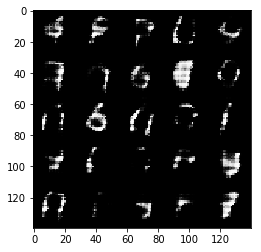

Epoch 1/2... Discriminator Loss: 1.3767... Generator Loss: 0.6857... TS: 2017-08-25 07:17:00.770745
Epoch 1/2... Discriminator Loss: 1.3650... Generator Loss: 0.8720... TS: 2017-08-25 07:17:03.180489
Epoch 1/2... Discriminator Loss: 1.5590... Generator Loss: 0.5568... TS: 2017-08-25 07:17:05.556493
Epoch 1/2... Discriminator Loss: 1.4298... Generator Loss: 0.5848... TS: 2017-08-25 07:17:07.933971
Epoch 1/2... Discriminator Loss: 1.3409... Generator Loss: 0.8231... TS: 2017-08-25 07:17:10.288803


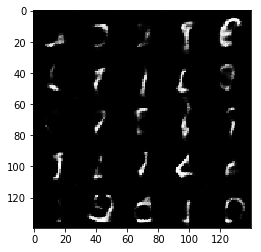

Epoch 1/2... Discriminator Loss: 1.4526... Generator Loss: 0.5277... TS: 2017-08-25 07:17:13.327299
Epoch 1/2... Discriminator Loss: 1.3772... Generator Loss: 0.6458... TS: 2017-08-25 07:17:15.700628
Epoch 1/2... Discriminator Loss: 1.3563... Generator Loss: 0.8246... TS: 2017-08-25 07:17:18.086892
Epoch 1/2... Discriminator Loss: 1.2991... Generator Loss: 1.0224... TS: 2017-08-25 07:17:20.465056
Epoch 1/2... Discriminator Loss: 1.4576... Generator Loss: 0.5367... TS: 2017-08-25 07:17:22.972753


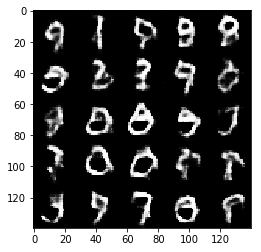

Epoch 1/2... Discriminator Loss: 1.4178... Generator Loss: 0.6485... TS: 2017-08-25 07:17:26.123989
Epoch 1/2... Discriminator Loss: 1.4690... Generator Loss: 0.5432... TS: 2017-08-25 07:17:28.655599
Epoch 1/2... Discriminator Loss: 1.3946... Generator Loss: 0.7263... TS: 2017-08-25 07:17:31.152178
Epoch 1/2... Discriminator Loss: 1.3719... Generator Loss: 0.7352... TS: 2017-08-25 07:17:33.666364
Epoch 1/2... Discriminator Loss: 1.3529... Generator Loss: 0.7688... TS: 2017-08-25 07:17:36.051784


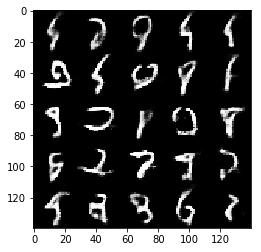

Epoch 1/2... Discriminator Loss: 1.4130... Generator Loss: 0.7438... TS: 2017-08-25 07:17:39.082770
Epoch 1/2... Discriminator Loss: 1.3421... Generator Loss: 0.7470... TS: 2017-08-25 07:17:41.501931
Epoch 1/2... Discriminator Loss: 1.4077... Generator Loss: 0.9023... TS: 2017-08-25 07:17:43.874468
Epoch 1/2... Discriminator Loss: 1.3642... Generator Loss: 0.6462... TS: 2017-08-25 07:17:46.249679
Epoch 1/2... Discriminator Loss: 1.3705... Generator Loss: 0.8473... TS: 2017-08-25 07:17:48.613949


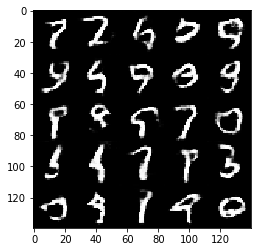

Epoch 1/2... Discriminator Loss: 1.5245... Generator Loss: 0.4725... TS: 2017-08-25 07:17:51.612002
Epoch 1/2... Discriminator Loss: 1.4156... Generator Loss: 0.6216... TS: 2017-08-25 07:17:54.001056
Epoch 1/2... Discriminator Loss: 1.3767... Generator Loss: 0.7477... TS: 2017-08-25 07:17:56.396631
Epoch 1/2... Discriminator Loss: 1.3723... Generator Loss: 0.6112... TS: 2017-08-25 07:17:58.765788
Epoch 1/2... Discriminator Loss: 1.4025... Generator Loss: 0.5735... TS: 2017-08-25 07:18:01.113962


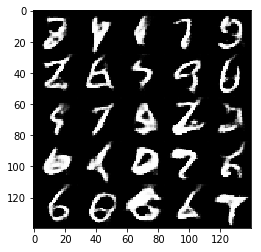

Epoch 1/2... Discriminator Loss: 1.3759... Generator Loss: 1.0353... TS: 2017-08-25 07:18:04.078502
Epoch 1/2... Discriminator Loss: 1.3561... Generator Loss: 1.0380... TS: 2017-08-25 07:18:06.425518
Epoch 1/2... Discriminator Loss: 1.3311... Generator Loss: 0.6855... TS: 2017-08-25 07:18:08.804908
Epoch 1/2... Discriminator Loss: 1.3658... Generator Loss: 0.8282... TS: 2017-08-25 07:18:11.179098
Epoch 1/2... Discriminator Loss: 1.3407... Generator Loss: 1.0366... TS: 2017-08-25 07:18:13.562675


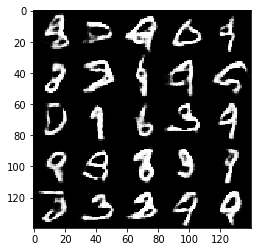

Epoch 1/2... Discriminator Loss: 1.3494... Generator Loss: 0.6809... TS: 2017-08-25 07:18:16.532523
Epoch 1/2... Discriminator Loss: 1.4188... Generator Loss: 1.0273... TS: 2017-08-25 07:18:18.963000
Epoch 1/2... Discriminator Loss: 1.3594... Generator Loss: 0.9056... TS: 2017-08-25 07:18:21.327500
Epoch 1/2... Discriminator Loss: 1.3836... Generator Loss: 0.6646... TS: 2017-08-25 07:18:24.118138
Epoch 1/2... Discriminator Loss: 1.3802... Generator Loss: 0.5860... TS: 2017-08-25 07:18:32.245659


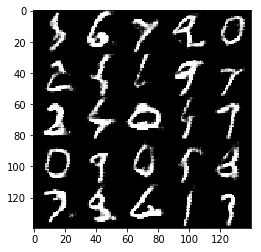

Epoch 1/2... Discriminator Loss: 1.4484... Generator Loss: 1.1106... TS: 2017-08-25 07:18:38.710808
Epoch 1/2... Discriminator Loss: 1.3531... Generator Loss: 0.8837... TS: 2017-08-25 07:18:41.062537
Epoch 1/2... Discriminator Loss: 1.3758... Generator Loss: 0.6744... TS: 2017-08-25 07:18:43.422043
Epoch 1/2... Discriminator Loss: 1.3666... Generator Loss: 0.6684... TS: 2017-08-25 07:18:45.788194
Epoch 1/2... Discriminator Loss: 1.4093... Generator Loss: 1.0859... TS: 2017-08-25 07:18:48.143076


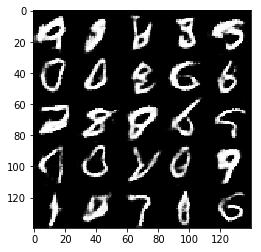

Epoch 1/2... Discriminator Loss: 1.3593... Generator Loss: 1.1072... TS: 2017-08-25 07:18:51.096591
Epoch 2/2... Discriminator Loss: 1.3150... Generator Loss: 0.9192... TS: 2017-08-25 07:18:55.429365
Epoch 2/2... Discriminator Loss: 1.3807... Generator Loss: 1.0852... TS: 2017-08-25 07:18:57.826265
Epoch 2/2... Discriminator Loss: 1.3046... Generator Loss: 1.0055... TS: 2017-08-25 07:19:00.177144
Epoch 2/2... Discriminator Loss: 1.3736... Generator Loss: 1.2306... TS: 2017-08-25 07:19:02.523058
Epoch 2/2... Discriminator Loss: 1.3064... Generator Loss: 0.8592... TS: 2017-08-25 07:19:04.896858


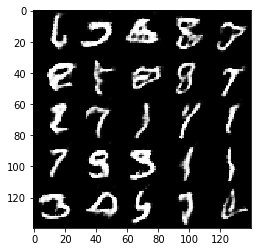

Epoch 2/2... Discriminator Loss: 1.3053... Generator Loss: 0.9484... TS: 2017-08-25 07:19:07.846698
Epoch 2/2... Discriminator Loss: 1.5984... Generator Loss: 1.5166... TS: 2017-08-25 07:19:10.219234
Epoch 2/2... Discriminator Loss: 1.2984... Generator Loss: 1.0184... TS: 2017-08-25 07:19:12.590732
Epoch 2/2... Discriminator Loss: 1.2955... Generator Loss: 0.8910... TS: 2017-08-25 07:19:14.972555
Epoch 2/2... Discriminator Loss: 1.4103... Generator Loss: 0.5462... TS: 2017-08-25 07:19:17.353064


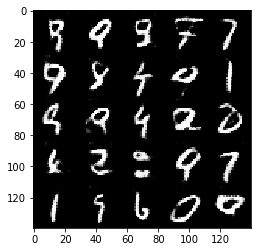

Epoch 2/2... Discriminator Loss: 1.2835... Generator Loss: 0.7547... TS: 2017-08-25 07:19:20.334241
Epoch 2/2... Discriminator Loss: 1.2966... Generator Loss: 0.8688... TS: 2017-08-25 07:19:22.723291
Epoch 2/2... Discriminator Loss: 1.3075... Generator Loss: 0.6918... TS: 2017-08-25 07:19:25.098761
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 1.3060... TS: 2017-08-25 07:19:27.473293
Epoch 2/2... Discriminator Loss: 1.3730... Generator Loss: 1.0405... TS: 2017-08-25 07:19:29.866400


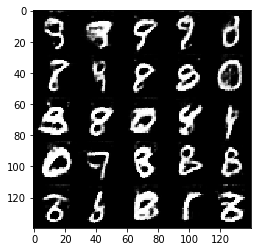

Epoch 2/2... Discriminator Loss: 1.3153... Generator Loss: 1.0820... TS: 2017-08-25 07:19:32.835207
Epoch 2/2... Discriminator Loss: 1.3580... Generator Loss: 0.7631... TS: 2017-08-25 07:19:35.194802
Epoch 2/2... Discriminator Loss: 1.3188... Generator Loss: 0.6715... TS: 2017-08-25 07:19:37.579398
Epoch 2/2... Discriminator Loss: 1.3501... Generator Loss: 0.7545... TS: 2017-08-25 07:19:39.956138
Epoch 2/2... Discriminator Loss: 1.3402... Generator Loss: 1.0819... TS: 2017-08-25 07:19:42.331208


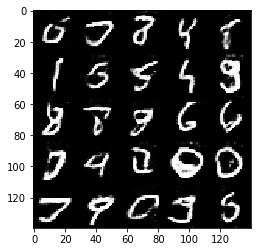

Epoch 2/2... Discriminator Loss: 1.3248... Generator Loss: 0.8365... TS: 2017-08-25 07:19:45.311820
Epoch 2/2... Discriminator Loss: 1.3060... Generator Loss: 0.7912... TS: 2017-08-25 07:19:47.715582
Epoch 2/2... Discriminator Loss: 1.4210... Generator Loss: 0.5919... TS: 2017-08-25 07:19:50.076633
Epoch 2/2... Discriminator Loss: 1.3207... Generator Loss: 0.7152... TS: 2017-08-25 07:19:52.452568
Epoch 2/2... Discriminator Loss: 1.3818... Generator Loss: 1.0973... TS: 2017-08-25 07:19:54.850394


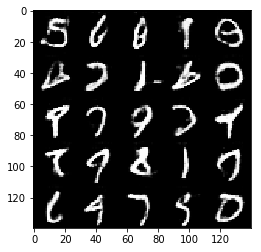

Epoch 2/2... Discriminator Loss: 1.3162... Generator Loss: 0.9025... TS: 2017-08-25 07:19:57.851371
Epoch 2/2... Discriminator Loss: 1.3617... Generator Loss: 0.9948... TS: 2017-08-25 07:20:00.257153
Epoch 2/2... Discriminator Loss: 1.2964... Generator Loss: 0.8781... TS: 2017-08-25 07:20:02.658893
Epoch 2/2... Discriminator Loss: 1.3231... Generator Loss: 0.9840... TS: 2017-08-25 07:20:05.059374
Epoch 2/2... Discriminator Loss: 1.3786... Generator Loss: 0.8131... TS: 2017-08-25 07:20:07.471136


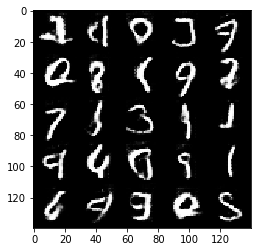

Epoch 2/2... Discriminator Loss: 1.3198... Generator Loss: 1.0889... TS: 2017-08-25 07:20:10.469857
Epoch 2/2... Discriminator Loss: 1.3942... Generator Loss: 0.5973... TS: 2017-08-25 07:20:12.879921
Epoch 2/2... Discriminator Loss: 1.3077... Generator Loss: 0.6924... TS: 2017-08-25 07:20:15.239802
Epoch 2/2... Discriminator Loss: 1.4047... Generator Loss: 0.5891... TS: 2017-08-25 07:20:17.652659
Epoch 2/2... Discriminator Loss: 1.2480... Generator Loss: 0.7111... TS: 2017-08-25 07:20:20.058128


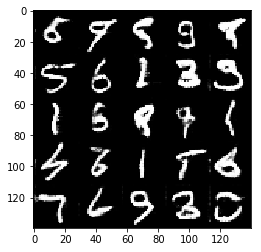

Epoch 2/2... Discriminator Loss: 1.2038... Generator Loss: 0.8042... TS: 2017-08-25 07:20:23.033997
Epoch 2/2... Discriminator Loss: 1.2985... Generator Loss: 0.8153... TS: 2017-08-25 07:20:25.430535
Epoch 2/2... Discriminator Loss: 1.3678... Generator Loss: 0.6866... TS: 2017-08-25 07:20:27.838276
Epoch 2/2... Discriminator Loss: 1.4701... Generator Loss: 1.1814... TS: 2017-08-25 07:20:30.243179
Epoch 2/2... Discriminator Loss: 1.4048... Generator Loss: 0.5879... TS: 2017-08-25 07:20:32.648311


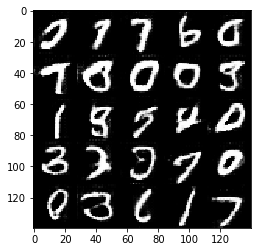

Epoch 2/2... Discriminator Loss: 1.3836... Generator Loss: 1.0981... TS: 2017-08-25 07:20:35.649293
Epoch 2/2... Discriminator Loss: 1.3377... Generator Loss: 1.2086... TS: 2017-08-25 07:20:38.065352
Epoch 2/2... Discriminator Loss: 1.3356... Generator Loss: 0.7535... TS: 2017-08-25 07:20:40.485608
Epoch 2/2... Discriminator Loss: 1.3170... Generator Loss: 0.9904... TS: 2017-08-25 07:20:42.892838
Epoch 2/2... Discriminator Loss: 1.3348... Generator Loss: 0.7196... TS: 2017-08-25 07:20:45.283900


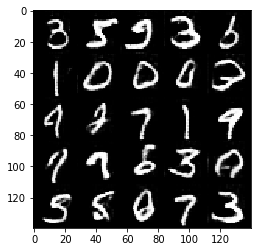

Epoch 2/2... Discriminator Loss: 1.3107... Generator Loss: 0.8898... TS: 2017-08-25 07:20:48.283305


In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 2.4045... Generator Loss: 0.2074... TS: 2017-08-25 07:21:13.172180
Epoch 1/2... Discriminator Loss: 1.7246... Generator Loss: 0.4381... TS: 2017-08-25 07:21:26.053675
Epoch 1/2... Discriminator Loss: 1.1155... Generator Loss: 0.9960... TS: 2017-08-25 07:21:38.771936
Epoch 1/2... Discriminator Loss: 0.7080... Generator Loss: 1.4893... TS: 2017-08-25 07:22:13.438964
Epoch 1/2... Discriminator Loss: 0.7935... Generator Loss: 1.5602... TS: 2017-08-25 07:22:26.181891


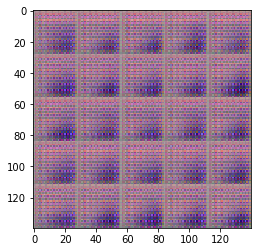

Epoch 1/2... Discriminator Loss: 0.7547... Generator Loss: 1.3249... TS: 2017-08-25 07:22:39.481966
Epoch 1/2... Discriminator Loss: 1.0443... Generator Loss: 1.2157... TS: 2017-08-25 07:22:52.302097
Epoch 1/2... Discriminator Loss: 0.9709... Generator Loss: 1.0445... TS: 2017-08-25 07:23:04.988592
Epoch 1/2... Discriminator Loss: 1.0484... Generator Loss: 1.1383... TS: 2017-08-25 07:23:17.747700
Epoch 1/2... Discriminator Loss: 0.9117... Generator Loss: 1.1009... TS: 2017-08-25 07:23:30.235184


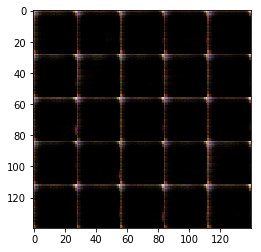

Epoch 1/2... Discriminator Loss: 0.9056... Generator Loss: 1.1572... TS: 2017-08-25 07:23:43.716427
Epoch 1/2... Discriminator Loss: 1.0111... Generator Loss: 1.2250... TS: 2017-08-25 07:23:56.139626
Epoch 1/2... Discriminator Loss: 0.9641... Generator Loss: 0.9236... TS: 2017-08-25 07:24:10.452324
Epoch 1/2... Discriminator Loss: 0.9560... Generator Loss: 1.5903... TS: 2017-08-25 07:24:23.436318
Epoch 1/2... Discriminator Loss: 0.9463... Generator Loss: 1.1346... TS: 2017-08-25 07:24:36.235941


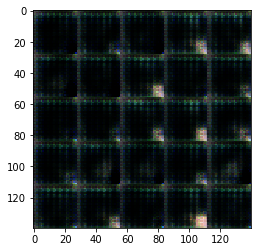

Epoch 1/2... Discriminator Loss: 0.9706... Generator Loss: 1.1780... TS: 2017-08-25 07:24:49.764539
Epoch 1/2... Discriminator Loss: 0.9270... Generator Loss: 1.1434... TS: 2017-08-25 07:25:02.630626
Epoch 1/2... Discriminator Loss: 1.0136... Generator Loss: 1.0136... TS: 2017-08-25 07:25:15.206265
Epoch 1/2... Discriminator Loss: 0.9801... Generator Loss: 1.3686... TS: 2017-08-25 07:25:27.762574
Epoch 1/2... Discriminator Loss: 1.1785... Generator Loss: 1.1794... TS: 2017-08-25 07:25:40.869139


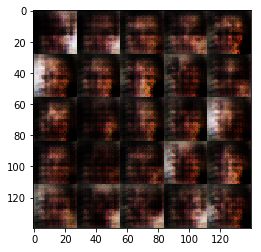

Epoch 1/2... Discriminator Loss: 1.0713... Generator Loss: 1.0427... TS: 2017-08-25 07:25:54.136711
Epoch 1/2... Discriminator Loss: 1.1017... Generator Loss: 0.9771... TS: 2017-08-25 07:26:07.288017
Epoch 1/2... Discriminator Loss: 1.2708... Generator Loss: 0.7974... TS: 2017-08-25 07:26:20.586871
Epoch 1/2... Discriminator Loss: 1.1536... Generator Loss: 0.9731... TS: 2017-08-25 07:26:33.476390
Epoch 1/2... Discriminator Loss: 1.1795... Generator Loss: 0.9315... TS: 2017-08-25 07:26:46.583291


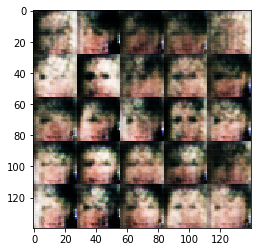

Epoch 1/2... Discriminator Loss: 1.4196... Generator Loss: 0.9750... TS: 2017-08-25 07:26:59.912519
Epoch 1/2... Discriminator Loss: 1.1516... Generator Loss: 1.0472... TS: 2017-08-25 07:27:12.733069
Epoch 1/2... Discriminator Loss: 1.1596... Generator Loss: 1.0202... TS: 2017-08-25 07:27:25.369437
Epoch 1/2... Discriminator Loss: 1.3559... Generator Loss: 1.4316... TS: 2017-08-25 07:27:37.884422
Epoch 1/2... Discriminator Loss: 1.1022... Generator Loss: 0.9938... TS: 2017-08-25 07:27:50.863797


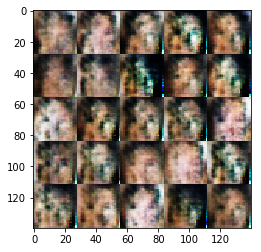

Epoch 1/2... Discriminator Loss: 1.2402... Generator Loss: 0.9201... TS: 2017-08-25 07:28:04.099953
Epoch 1/2... Discriminator Loss: 1.1495... Generator Loss: 0.9448... TS: 2017-08-25 07:28:17.101770
Epoch 1/2... Discriminator Loss: 1.1835... Generator Loss: 0.8755... TS: 2017-08-25 07:28:29.576759
Epoch 1/2... Discriminator Loss: 1.2586... Generator Loss: 0.8993... TS: 2017-08-25 07:28:43.302646
Epoch 1/2... Discriminator Loss: 1.7788... Generator Loss: 1.4004... TS: 2017-08-25 07:28:56.827889


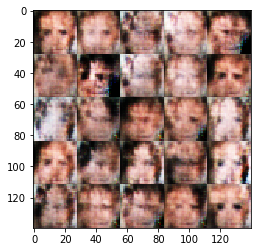

Epoch 1/2... Discriminator Loss: 1.2142... Generator Loss: 1.1121... TS: 2017-08-25 07:29:11.429788
Epoch 1/2... Discriminator Loss: 1.1629... Generator Loss: 0.9007... TS: 2017-08-25 07:29:24.285802
Epoch 1/2... Discriminator Loss: 1.0890... Generator Loss: 1.2645... TS: 2017-08-25 07:29:37.175603
Epoch 1/2... Discriminator Loss: 1.2988... Generator Loss: 0.8977... TS: 2017-08-25 07:29:49.982958
Epoch 1/2... Discriminator Loss: 1.3047... Generator Loss: 0.9927... TS: 2017-08-25 07:30:03.662158


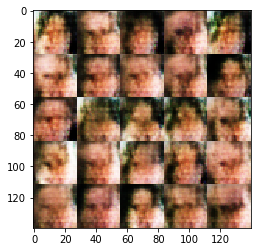

Epoch 1/2... Discriminator Loss: 1.1467... Generator Loss: 0.9964... TS: 2017-08-25 07:30:17.348335
Epoch 1/2... Discriminator Loss: 1.2702... Generator Loss: 1.0127... TS: 2017-08-25 07:30:29.945016
Epoch 1/2... Discriminator Loss: 1.1745... Generator Loss: 0.9600... TS: 2017-08-25 07:30:42.693709
Epoch 1/2... Discriminator Loss: 1.4933... Generator Loss: 1.0228... TS: 2017-08-25 07:30:56.062014
Epoch 1/2... Discriminator Loss: 1.3525... Generator Loss: 1.1358... TS: 2017-08-25 07:31:08.995144


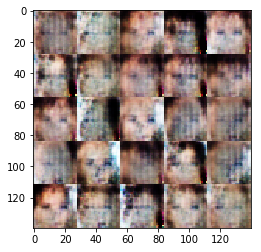

Epoch 1/2... Discriminator Loss: 1.2002... Generator Loss: 0.9111... TS: 2017-08-25 07:31:24.417487
Epoch 1/2... Discriminator Loss: 1.1986... Generator Loss: 0.9052... TS: 2017-08-25 07:31:40.832529
Epoch 1/2... Discriminator Loss: 1.3590... Generator Loss: 0.7878... TS: 2017-08-25 07:31:56.746364
Epoch 1/2... Discriminator Loss: 1.2884... Generator Loss: 0.8692... TS: 2017-08-25 07:32:12.057594
Epoch 1/2... Discriminator Loss: 1.2161... Generator Loss: 0.9264... TS: 2017-08-25 07:32:27.640657


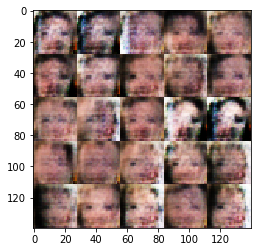

Epoch 1/2... Discriminator Loss: 1.3937... Generator Loss: 0.8825... TS: 2017-08-25 07:32:43.277969
Epoch 1/2... Discriminator Loss: 1.3050... Generator Loss: 0.8733... TS: 2017-08-25 07:32:58.438075
Epoch 1/2... Discriminator Loss: 1.1793... Generator Loss: 0.9179... TS: 2017-08-25 07:33:12.897914
Epoch 1/2... Discriminator Loss: 1.2441... Generator Loss: 0.8816... TS: 2017-08-25 07:33:27.518131
Epoch 1/2... Discriminator Loss: 1.3181... Generator Loss: 0.8011... TS: 2017-08-25 07:33:42.916453


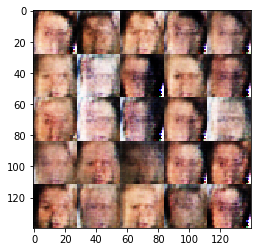

Epoch 1/2... Discriminator Loss: 1.2498... Generator Loss: 0.8236... TS: 2017-08-25 07:33:58.383704
Epoch 1/2... Discriminator Loss: 1.4754... Generator Loss: 1.1561... TS: 2017-08-25 07:34:13.495774
Epoch 1/2... Discriminator Loss: 1.3107... Generator Loss: 1.0336... TS: 2017-08-25 07:34:28.769023
Epoch 1/2... Discriminator Loss: 1.2131... Generator Loss: 0.8964... TS: 2017-08-25 07:34:44.026246
Epoch 1/2... Discriminator Loss: 1.2472... Generator Loss: 0.9186... TS: 2017-08-25 07:34:59.434861


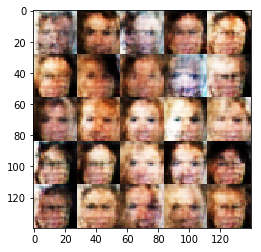

Epoch 1/2... Discriminator Loss: 1.2405... Generator Loss: 0.9305... TS: 2017-08-25 07:35:18.920463
Epoch 1/2... Discriminator Loss: 1.2503... Generator Loss: 0.9180... TS: 2017-08-25 07:35:34.296577
Epoch 1/2... Discriminator Loss: 1.1739... Generator Loss: 0.9614... TS: 2017-08-25 07:35:48.948877
Epoch 1/2... Discriminator Loss: 1.1328... Generator Loss: 1.0642... TS: 2017-08-25 07:36:03.932719
Epoch 1/2... Discriminator Loss: 1.2936... Generator Loss: 0.9315... TS: 2017-08-25 07:36:22.636094


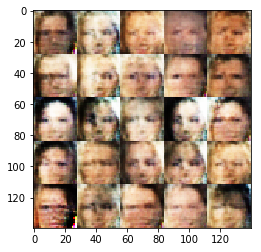

Epoch 1/2... Discriminator Loss: 1.2366... Generator Loss: 0.9792... TS: 2017-08-25 07:36:45.783969
Epoch 1/2... Discriminator Loss: 1.4156... Generator Loss: 1.1298... TS: 2017-08-25 07:37:09.491549
Epoch 1/2... Discriminator Loss: 1.3096... Generator Loss: 0.9221... TS: 2017-08-25 07:37:32.254736
Epoch 1/2... Discriminator Loss: 1.3480... Generator Loss: 0.8641... TS: 2017-08-25 07:37:58.287806
Epoch 1/2... Discriminator Loss: 1.3787... Generator Loss: 0.7273... TS: 2017-08-25 07:38:25.723138


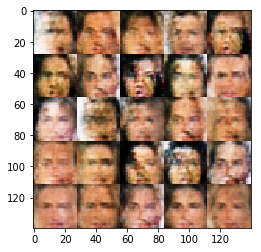

Epoch 1/2... Discriminator Loss: 1.2833... Generator Loss: 0.8770... TS: 2017-08-25 07:38:49.390673
Epoch 1/2... Discriminator Loss: 1.2450... Generator Loss: 0.8912... TS: 2017-08-25 07:39:15.950157
Epoch 1/2... Discriminator Loss: 1.3112... Generator Loss: 0.8260... TS: 2017-08-25 07:39:43.806303
Epoch 1/2... Discriminator Loss: 1.2615... Generator Loss: 1.0500... TS: 2017-08-25 07:40:11.158814
Epoch 1/2... Discriminator Loss: 1.2600... Generator Loss: 0.9303... TS: 2017-08-25 07:40:43.233904


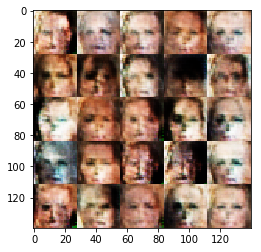

Epoch 1/2... Discriminator Loss: 1.2256... Generator Loss: 0.9885... TS: 2017-08-25 07:41:16.560646
Epoch 1/2... Discriminator Loss: 1.3036... Generator Loss: 0.8792... TS: 2017-08-25 07:41:41.678766
Epoch 1/2... Discriminator Loss: 1.2806... Generator Loss: 0.7659... TS: 2017-08-25 07:42:06.699100
Epoch 1/2... Discriminator Loss: 1.2955... Generator Loss: 0.9571... TS: 2017-08-25 07:42:30.780633
Epoch 1/2... Discriminator Loss: 1.2412... Generator Loss: 0.8839... TS: 2017-08-25 07:42:53.445940


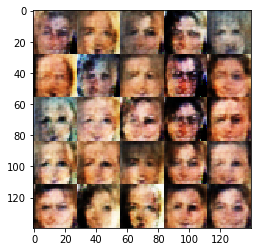

Epoch 1/2... Discriminator Loss: 1.3113... Generator Loss: 0.9260... TS: 2017-08-25 07:43:20.032050
Epoch 1/2... Discriminator Loss: 1.4784... Generator Loss: 0.6474... TS: 2017-08-25 07:43:39.128993
Epoch 1/2... Discriminator Loss: 1.3327... Generator Loss: 0.8574... TS: 2017-08-25 07:43:54.765355
Epoch 1/2... Discriminator Loss: 1.4038... Generator Loss: 0.7573... TS: 2017-08-25 07:44:10.507792
Epoch 1/2... Discriminator Loss: 1.2799... Generator Loss: 0.8883... TS: 2017-08-25 07:44:25.150744


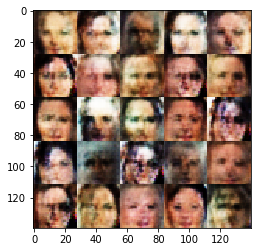

Epoch 1/2... Discriminator Loss: 1.2961... Generator Loss: 0.8691... TS: 2017-08-25 07:44:41.378694
Epoch 1/2... Discriminator Loss: 1.3005... Generator Loss: 0.9158... TS: 2017-08-25 07:44:55.897333
Epoch 1/2... Discriminator Loss: 1.3364... Generator Loss: 0.8670... TS: 2017-08-25 07:45:11.504381
Epoch 1/2... Discriminator Loss: 1.3107... Generator Loss: 0.8548... TS: 2017-08-25 07:45:26.151364
Epoch 1/2... Discriminator Loss: 1.2709... Generator Loss: 0.8989... TS: 2017-08-25 07:45:41.333478


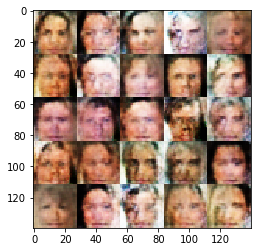

Epoch 1/2... Discriminator Loss: 1.3000... Generator Loss: 0.7959... TS: 2017-08-25 07:45:57.294820
Epoch 1/2... Discriminator Loss: 1.3055... Generator Loss: 0.8208... TS: 2017-08-25 07:46:12.604999
Epoch 1/2... Discriminator Loss: 1.3753... Generator Loss: 0.8177... TS: 2017-08-25 07:46:27.670550
Epoch 1/2... Discriminator Loss: 1.3467... Generator Loss: 0.9887... TS: 2017-08-25 07:46:42.609538
Epoch 1/2... Discriminator Loss: 1.2713... Generator Loss: 0.8769... TS: 2017-08-25 07:46:57.958638


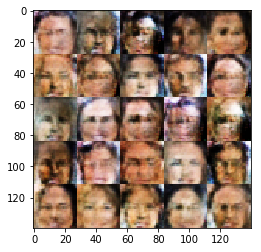

Epoch 1/2... Discriminator Loss: 1.2605... Generator Loss: 0.8583... TS: 2017-08-25 07:47:13.539691
Epoch 1/2... Discriminator Loss: 1.4186... Generator Loss: 0.7873... TS: 2017-08-25 07:47:28.463481
Epoch 1/2... Discriminator Loss: 1.2755... Generator Loss: 0.9183... TS: 2017-08-25 07:47:43.399589
Epoch 1/2... Discriminator Loss: 1.3106... Generator Loss: 0.8142... TS: 2017-08-25 07:47:58.469864
Epoch 1/2... Discriminator Loss: 1.3291... Generator Loss: 0.9505... TS: 2017-08-25 07:48:13.231731


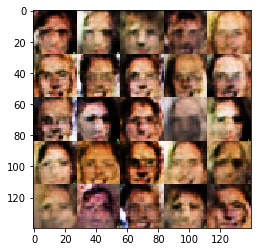

Epoch 1/2... Discriminator Loss: 1.3315... Generator Loss: 0.7649... TS: 2017-08-25 07:48:28.930273
Epoch 1/2... Discriminator Loss: 1.3114... Generator Loss: 0.8647... TS: 2017-08-25 07:48:44.166532
Epoch 1/2... Discriminator Loss: 1.3104... Generator Loss: 0.7806... TS: 2017-08-25 07:48:59.215649
Epoch 1/2... Discriminator Loss: 1.3225... Generator Loss: 0.9727... TS: 2017-08-25 07:49:15.401064
Epoch 1/2... Discriminator Loss: 1.3682... Generator Loss: 0.9737... TS: 2017-08-25 07:49:30.908404


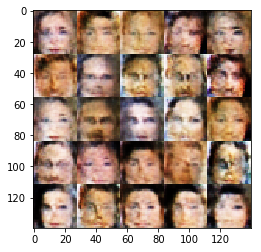

Epoch 1/2... Discriminator Loss: 1.3197... Generator Loss: 0.8142... TS: 2017-08-25 07:49:46.405393
Epoch 1/2... Discriminator Loss: 1.3136... Generator Loss: 0.8300... TS: 2017-08-25 07:50:01.601390
Epoch 1/2... Discriminator Loss: 1.3014... Generator Loss: 0.8323... TS: 2017-08-25 07:50:16.345959
Epoch 1/2... Discriminator Loss: 1.3657... Generator Loss: 0.9207... TS: 2017-08-25 07:50:31.427284
Epoch 1/2... Discriminator Loss: 1.3477... Generator Loss: 0.8908... TS: 2017-08-25 07:50:46.614964


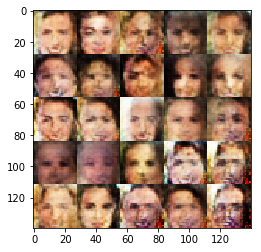

Epoch 1/2... Discriminator Loss: 1.3733... Generator Loss: 0.8052... TS: 2017-08-25 07:51:03.751254
Epoch 1/2... Discriminator Loss: 1.3408... Generator Loss: 0.7835... TS: 2017-08-25 07:51:19.008715
Epoch 1/2... Discriminator Loss: 1.4105... Generator Loss: 0.9639... TS: 2017-08-25 07:51:33.967458
Epoch 1/2... Discriminator Loss: 1.3294... Generator Loss: 0.8203... TS: 2017-08-25 07:51:49.363230
Epoch 1/2... Discriminator Loss: 1.4153... Generator Loss: 0.7600... TS: 2017-08-25 07:52:05.276867


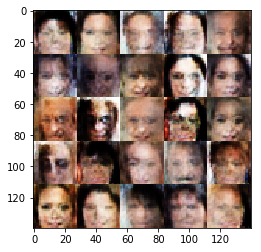

Epoch 1/2... Discriminator Loss: 1.3649... Generator Loss: 0.8702... TS: 2017-08-25 07:52:20.880499
Epoch 1/2... Discriminator Loss: 1.3321... Generator Loss: 0.7809... TS: 2017-08-25 07:52:35.966432
Epoch 1/2... Discriminator Loss: 1.4313... Generator Loss: 0.7634... TS: 2017-08-25 07:52:50.833173
Epoch 1/2... Discriminator Loss: 1.2979... Generator Loss: 0.8622... TS: 2017-08-25 07:53:05.965149
Epoch 1/2... Discriminator Loss: 1.3361... Generator Loss: 0.8617... TS: 2017-08-25 07:53:21.119869


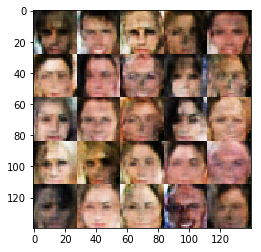

Epoch 1/2... Discriminator Loss: 1.3382... Generator Loss: 0.8770... TS: 2017-08-25 07:53:36.614250
Epoch 1/2... Discriminator Loss: 1.4022... Generator Loss: 0.9112... TS: 2017-08-25 07:53:52.117229
Epoch 1/2... Discriminator Loss: 1.4083... Generator Loss: 0.7930... TS: 2017-08-25 07:54:07.295734
Epoch 1/2... Discriminator Loss: 1.3676... Generator Loss: 0.7820... TS: 2017-08-25 07:54:22.504624
Epoch 1/2... Discriminator Loss: 1.3700... Generator Loss: 0.8644... TS: 2017-08-25 07:54:39.530396


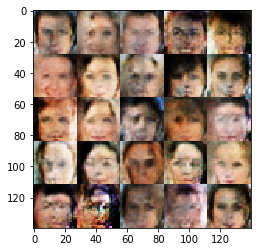

Epoch 1/2... Discriminator Loss: 1.3240... Generator Loss: 0.8541... TS: 2017-08-25 07:54:55.952468
Epoch 1/2... Discriminator Loss: 1.3541... Generator Loss: 0.7455... TS: 2017-08-25 07:55:10.607572
Epoch 1/2... Discriminator Loss: 1.3617... Generator Loss: 0.7512... TS: 2017-08-25 07:55:25.455745
Epoch 1/2... Discriminator Loss: 1.3645... Generator Loss: 0.8585... TS: 2017-08-25 07:55:40.649426
Epoch 1/2... Discriminator Loss: 1.3584... Generator Loss: 0.7920... TS: 2017-08-25 07:55:55.751381


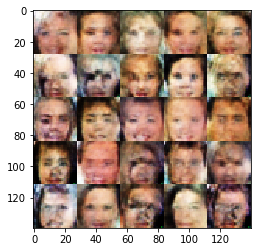

Epoch 1/2... Discriminator Loss: 1.2612... Generator Loss: 0.9028... TS: 2017-08-25 07:56:11.483829
Epoch 1/2... Discriminator Loss: 1.3779... Generator Loss: 0.7863... TS: 2017-08-25 07:56:26.678552
Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 0.8011... TS: 2017-08-25 07:56:41.960856
Epoch 1/2... Discriminator Loss: 1.3083... Generator Loss: 0.8060... TS: 2017-08-25 07:56:56.921210
Epoch 1/2... Discriminator Loss: 1.4126... Generator Loss: 0.7452... TS: 2017-08-25 07:57:12.113702


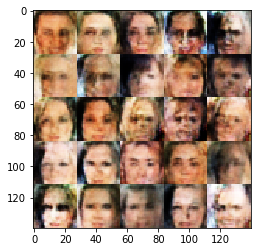

Epoch 1/2... Discriminator Loss: 1.3536... Generator Loss: 0.8138... TS: 2017-08-25 07:57:27.828107
Epoch 1/2... Discriminator Loss: 1.3972... Generator Loss: 0.7871... TS: 2017-08-25 07:57:43.116500
Epoch 1/2... Discriminator Loss: 1.3876... Generator Loss: 0.8777... TS: 2017-08-25 07:57:58.413727
Epoch 1/2... Discriminator Loss: 1.4032... Generator Loss: 0.8210... TS: 2017-08-25 07:58:13.498931
Epoch 1/2... Discriminator Loss: 1.3830... Generator Loss: 0.7668... TS: 2017-08-25 07:58:31.190540


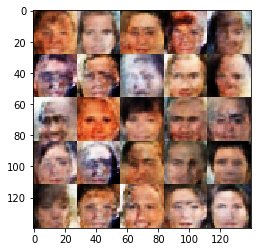

Epoch 1/2... Discriminator Loss: 1.3786... Generator Loss: 0.8169... TS: 2017-08-25 07:58:47.627136
Epoch 1/2... Discriminator Loss: 1.3208... Generator Loss: 0.8166... TS: 2017-08-25 07:59:03.074210
Epoch 1/2... Discriminator Loss: 1.4366... Generator Loss: 0.7852... TS: 2017-08-25 07:59:18.301252
Epoch 1/2... Discriminator Loss: 1.4846... Generator Loss: 0.7892... TS: 2017-08-25 07:59:33.340930
Epoch 1/2... Discriminator Loss: 1.2598... Generator Loss: 0.8519... TS: 2017-08-25 07:59:51.158161


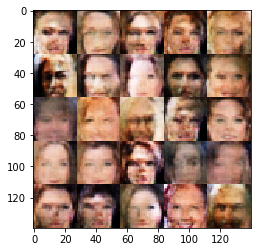

Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 0.8141... TS: 2017-08-25 08:00:32.746430
Epoch 1/2... Discriminator Loss: 1.4308... Generator Loss: 0.7132... TS: 2017-08-25 08:01:10.858076
Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 0.6655... TS: 2017-08-25 08:01:49.956166
Epoch 1/2... Discriminator Loss: 1.4186... Generator Loss: 0.7046... TS: 2017-08-25 08:02:31.402729
Epoch 1/2... Discriminator Loss: 1.4192... Generator Loss: 0.8252... TS: 2017-08-25 08:03:07.128060


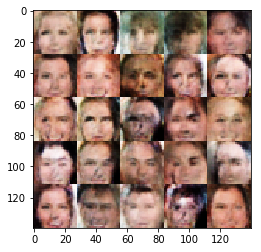

Epoch 1/2... Discriminator Loss: 1.5572... Generator Loss: 0.8982... TS: 2017-08-25 08:03:44.056722
Epoch 1/2... Discriminator Loss: 1.3927... Generator Loss: 0.7381... TS: 2017-08-25 08:04:16.331276
Epoch 1/2... Discriminator Loss: 1.3995... Generator Loss: 0.7960... TS: 2017-08-25 08:04:39.039452
Epoch 1/2... Discriminator Loss: 1.3069... Generator Loss: 0.7986... TS: 2017-08-25 08:04:53.957006
Epoch 1/2... Discriminator Loss: 1.3246... Generator Loss: 0.8777... TS: 2017-08-25 08:05:09.062918


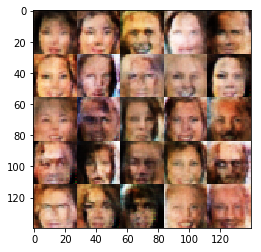

Epoch 1/2... Discriminator Loss: 1.3347... Generator Loss: 0.8405... TS: 2017-08-25 08:05:24.786314
Epoch 1/2... Discriminator Loss: 1.3287... Generator Loss: 0.8061... TS: 2017-08-25 08:05:39.836831
Epoch 1/2... Discriminator Loss: 1.3548... Generator Loss: 0.7657... TS: 2017-08-25 08:05:55.120313
Epoch 2/2... Discriminator Loss: 1.4039... Generator Loss: 0.7482... TS: 2017-08-25 08:06:16.878461
Epoch 2/2... Discriminator Loss: 1.3927... Generator Loss: 0.7508... TS: 2017-08-25 08:06:34.284578
Epoch 2/2... Discriminator Loss: 1.3368... Generator Loss: 0.7927... TS: 2017-08-25 08:06:50.572205
Epoch 2/2... Discriminator Loss: 1.3828... Generator Loss: 0.8603... TS: 2017-08-25 08:07:05.480678
Epoch 2/2... Discriminator Loss: 1.3704... Generator Loss: 0.8090... TS: 2017-08-25 08:07:20.335243


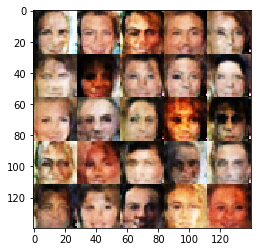

Epoch 2/2... Discriminator Loss: 1.3779... Generator Loss: 0.7416... TS: 2017-08-25 08:07:35.671730
Epoch 2/2... Discriminator Loss: 1.4155... Generator Loss: 0.6743... TS: 2017-08-25 08:07:51.025451
Epoch 2/2... Discriminator Loss: 1.3552... Generator Loss: 0.8075... TS: 2017-08-25 08:08:08.224281
Epoch 2/2... Discriminator Loss: 1.3705... Generator Loss: 0.8440... TS: 2017-08-25 08:08:24.437595
Epoch 2/2... Discriminator Loss: 1.3715... Generator Loss: 0.8047... TS: 2017-08-25 08:08:43.968301


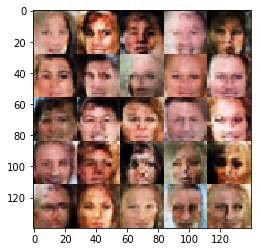

Epoch 2/2... Discriminator Loss: 1.4239... Generator Loss: 0.8965... TS: 2017-08-25 08:08:59.910290
Epoch 2/2... Discriminator Loss: 1.3651... Generator Loss: 0.7308... TS: 2017-08-25 08:09:15.580501
Epoch 2/2... Discriminator Loss: 1.4147... Generator Loss: 0.7937... TS: 2017-08-25 08:09:30.560032
Epoch 2/2... Discriminator Loss: 1.3218... Generator Loss: 0.9047... TS: 2017-08-25 08:09:45.576486
Epoch 2/2... Discriminator Loss: 1.3894... Generator Loss: 0.7843... TS: 2017-08-25 08:10:00.663625


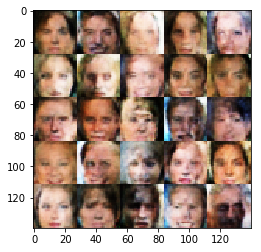

Epoch 2/2... Discriminator Loss: 1.4072... Generator Loss: 0.7947... TS: 2017-08-25 08:10:16.182683
Epoch 2/2... Discriminator Loss: 1.4916... Generator Loss: 0.7748... TS: 2017-08-25 08:10:31.506288
Epoch 2/2... Discriminator Loss: 1.3496... Generator Loss: 0.8128... TS: 2017-08-25 08:10:46.476512
Epoch 2/2... Discriminator Loss: 1.4080... Generator Loss: 0.7539... TS: 2017-08-25 08:11:01.830521
Epoch 2/2... Discriminator Loss: 1.3533... Generator Loss: 0.8311... TS: 2017-08-25 08:11:16.592016


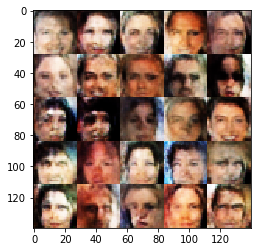

Epoch 2/2... Discriminator Loss: 1.3650... Generator Loss: 0.7967... TS: 2017-08-25 08:11:32.092336
Epoch 2/2... Discriminator Loss: 1.4111... Generator Loss: 0.7329... TS: 2017-08-25 08:11:47.248215
Epoch 2/2... Discriminator Loss: 1.4307... Generator Loss: 0.7099... TS: 2017-08-25 08:12:02.110984
Epoch 2/2... Discriminator Loss: 1.3319... Generator Loss: 0.8694... TS: 2017-08-25 08:12:17.109207
Epoch 2/2... Discriminator Loss: 1.3935... Generator Loss: 0.7719... TS: 2017-08-25 08:12:32.074616


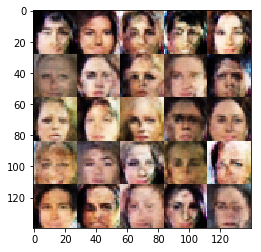

Epoch 2/2... Discriminator Loss: 1.4354... Generator Loss: 0.7588... TS: 2017-08-25 08:12:47.844459
Epoch 2/2... Discriminator Loss: 1.4336... Generator Loss: 0.7350... TS: 2017-08-25 08:13:02.888366
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.7343... TS: 2017-08-25 08:13:19.005332
Epoch 2/2... Discriminator Loss: 1.3669... Generator Loss: 0.7770... TS: 2017-08-25 08:13:34.789313
Epoch 2/2... Discriminator Loss: 1.3621... Generator Loss: 0.8359... TS: 2017-08-25 08:13:50.078808


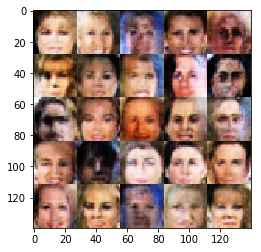

Epoch 2/2... Discriminator Loss: 1.3988... Generator Loss: 0.7539... TS: 2017-08-25 08:14:06.654266
Epoch 2/2... Discriminator Loss: 1.3962... Generator Loss: 0.8589... TS: 2017-08-25 08:14:21.759588
Epoch 2/2... Discriminator Loss: 1.3802... Generator Loss: 0.8898... TS: 2017-08-25 08:14:36.935638
Epoch 2/2... Discriminator Loss: 1.3860... Generator Loss: 0.7025... TS: 2017-08-25 08:14:52.324423
Epoch 2/2... Discriminator Loss: 1.4485... Generator Loss: 0.8547... TS: 2017-08-25 08:15:07.324584


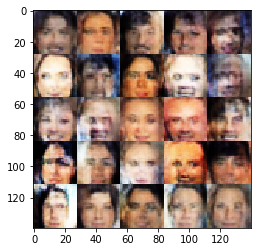

Epoch 2/2... Discriminator Loss: 1.3477... Generator Loss: 0.8030... TS: 2017-08-25 08:15:23.029637
Epoch 2/2... Discriminator Loss: 1.3273... Generator Loss: 0.7945... TS: 2017-08-25 08:15:38.526641
Epoch 2/2... Discriminator Loss: 1.4117... Generator Loss: 0.7911... TS: 2017-08-25 08:15:53.482865
Epoch 2/2... Discriminator Loss: 1.3738... Generator Loss: 0.7733... TS: 2017-08-25 08:16:08.714648
Epoch 2/2... Discriminator Loss: 1.4261... Generator Loss: 0.8216... TS: 2017-08-25 08:16:24.866215


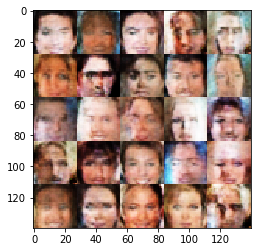

Epoch 2/2... Discriminator Loss: 1.4029... Generator Loss: 0.7793... TS: 2017-08-25 08:16:40.266630
Epoch 2/2... Discriminator Loss: 1.3584... Generator Loss: 0.9221... TS: 2017-08-25 08:16:55.390914
Epoch 2/2... Discriminator Loss: 1.3974... Generator Loss: 0.7615... TS: 2017-08-25 08:17:10.501303
Epoch 2/2... Discriminator Loss: 1.3714... Generator Loss: 0.7796... TS: 2017-08-25 08:17:25.075853
Epoch 2/2... Discriminator Loss: 1.3284... Generator Loss: 0.8616... TS: 2017-08-25 08:17:40.004382


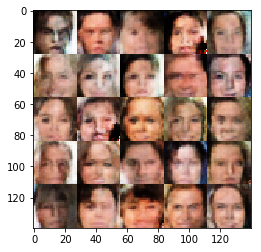

Epoch 2/2... Discriminator Loss: 1.3870... Generator Loss: 0.8502... TS: 2017-08-25 08:17:55.756084
Epoch 2/2... Discriminator Loss: 1.3933... Generator Loss: 0.6803... TS: 2017-08-25 08:18:11.379580
Epoch 2/2... Discriminator Loss: 1.4464... Generator Loss: 0.6922... TS: 2017-08-25 08:18:26.005849
Epoch 2/2... Discriminator Loss: 1.4182... Generator Loss: 0.7169... TS: 2017-08-25 08:18:42.965305
Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.7694... TS: 2017-08-25 08:18:58.148167


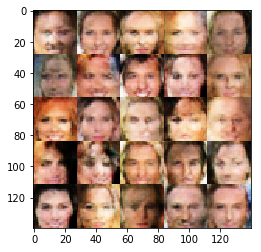

Epoch 2/2... Discriminator Loss: 1.4267... Generator Loss: 0.7928... TS: 2017-08-25 08:19:14.823394
Epoch 2/2... Discriminator Loss: 1.4018... Generator Loss: 0.8349... TS: 2017-08-25 08:19:30.167226
Epoch 2/2... Discriminator Loss: 1.3879... Generator Loss: 0.6974... TS: 2017-08-25 08:19:45.443892
Epoch 2/2... Discriminator Loss: 1.3436... Generator Loss: 0.7996... TS: 2017-08-25 08:20:00.272031
Epoch 2/2... Discriminator Loss: 1.3588... Generator Loss: 0.7365... TS: 2017-08-25 08:20:15.430641


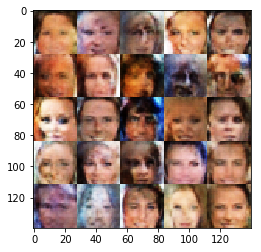

Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.7598... TS: 2017-08-25 08:20:30.795191
Epoch 2/2... Discriminator Loss: 1.3840... Generator Loss: 0.8596... TS: 2017-08-25 08:20:46.157739
Epoch 2/2... Discriminator Loss: 1.4161... Generator Loss: 0.8053... TS: 2017-08-25 08:21:01.051577
Epoch 2/2... Discriminator Loss: 1.3737... Generator Loss: 0.8016... TS: 2017-08-25 08:21:16.512605
Epoch 2/2... Discriminator Loss: 1.3639... Generator Loss: 0.8469... TS: 2017-08-25 08:21:31.295337


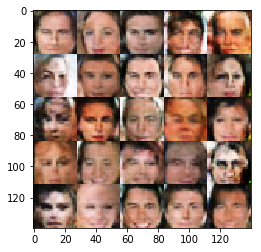

Epoch 2/2... Discriminator Loss: 1.3726... Generator Loss: 0.8466... TS: 2017-08-25 08:21:47.231037
Epoch 2/2... Discriminator Loss: 1.3663... Generator Loss: 0.8516... TS: 2017-08-25 08:22:02.289675
Epoch 2/2... Discriminator Loss: 1.4171... Generator Loss: 0.7502... TS: 2017-08-25 08:22:16.981335
Epoch 2/2... Discriminator Loss: 1.4152... Generator Loss: 0.8099... TS: 2017-08-25 08:22:31.888043
Epoch 2/2... Discriminator Loss: 1.4021... Generator Loss: 0.7936... TS: 2017-08-25 08:22:58.809055


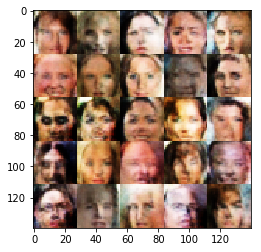

Epoch 2/2... Discriminator Loss: 1.3641... Generator Loss: 0.7867... TS: 2017-08-25 08:23:39.573674
Epoch 2/2... Discriminator Loss: 1.5499... Generator Loss: 0.7589... TS: 2017-08-25 08:24:16.236848
Epoch 2/2... Discriminator Loss: 1.4129... Generator Loss: 0.8460... TS: 2017-08-25 08:24:52.126332
Epoch 2/2... Discriminator Loss: 1.3922... Generator Loss: 0.8731... TS: 2017-08-25 08:25:26.957838
Epoch 2/2... Discriminator Loss: 1.3994... Generator Loss: 0.7950... TS: 2017-08-25 08:26:01.739059


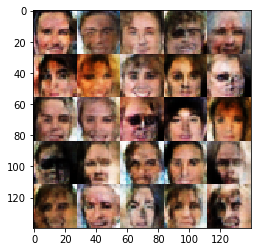

Epoch 2/2... Discriminator Loss: 1.3595... Generator Loss: 0.7826... TS: 2017-08-25 08:26:40.079785
Epoch 2/2... Discriminator Loss: 1.5874... Generator Loss: 0.8799... TS: 2017-08-25 08:27:19.138398
Epoch 2/2... Discriminator Loss: 1.3792... Generator Loss: 0.7202... TS: 2017-08-25 08:27:43.464551
Epoch 2/2... Discriminator Loss: 1.4019... Generator Loss: 0.7716... TS: 2017-08-25 08:27:58.848469
Epoch 2/2... Discriminator Loss: 1.4170... Generator Loss: 0.8444... TS: 2017-08-25 08:28:13.892442


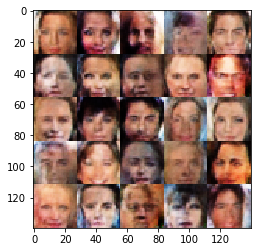

Epoch 2/2... Discriminator Loss: 1.4028... Generator Loss: 0.7795... TS: 2017-08-25 08:28:30.451098
Epoch 2/2... Discriminator Loss: 1.3958... Generator Loss: 0.7063... TS: 2017-08-25 08:28:45.497532
Epoch 2/2... Discriminator Loss: 1.3291... Generator Loss: 0.8693... TS: 2017-08-25 08:29:00.851194
Epoch 2/2... Discriminator Loss: 1.3919... Generator Loss: 0.7696... TS: 2017-08-25 08:29:16.318338
Epoch 2/2... Discriminator Loss: 1.3384... Generator Loss: 0.8378... TS: 2017-08-25 08:29:31.874247


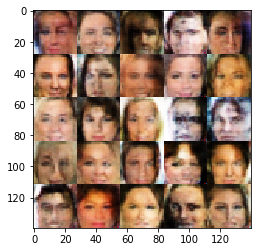

Epoch 2/2... Discriminator Loss: 1.3982... Generator Loss: 0.8395... TS: 2017-08-25 08:29:47.791633
Epoch 2/2... Discriminator Loss: 1.3361... Generator Loss: 0.7756... TS: 2017-08-25 08:30:02.734941
Epoch 2/2... Discriminator Loss: 1.6675... Generator Loss: 1.0603... TS: 2017-08-25 08:30:17.930265
Epoch 2/2... Discriminator Loss: 1.4185... Generator Loss: 0.7564... TS: 2017-08-25 08:30:34.634306
Epoch 2/2... Discriminator Loss: 1.4013... Generator Loss: 0.7991... TS: 2017-08-25 08:30:49.327559


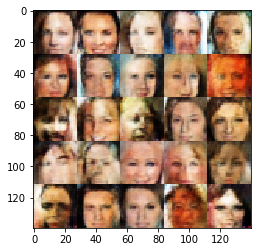

Epoch 2/2... Discriminator Loss: 1.3788... Generator Loss: 0.7731... TS: 2017-08-25 08:31:04.981485
Epoch 2/2... Discriminator Loss: 1.3715... Generator Loss: 0.7740... TS: 2017-08-25 08:31:19.351383
Epoch 2/2... Discriminator Loss: 1.4110... Generator Loss: 0.8259... TS: 2017-08-25 08:31:34.301629
Epoch 2/2... Discriminator Loss: 1.3660... Generator Loss: 0.8174... TS: 2017-08-25 08:31:49.551336
Epoch 2/2... Discriminator Loss: 1.4066... Generator Loss: 0.8106... TS: 2017-08-25 08:32:04.318511


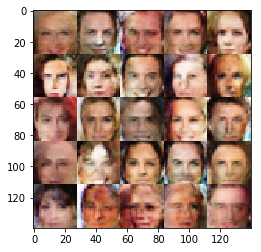

Epoch 2/2... Discriminator Loss: 1.3927... Generator Loss: 0.7743... TS: 2017-08-25 08:32:19.890518
Epoch 2/2... Discriminator Loss: 1.4151... Generator Loss: 0.8127... TS: 2017-08-25 08:32:35.175937
Epoch 2/2... Discriminator Loss: 1.3954... Generator Loss: 0.8388... TS: 2017-08-25 08:32:49.983331
Epoch 2/2... Discriminator Loss: 1.4046... Generator Loss: 0.8025... TS: 2017-08-25 08:33:04.890751
Epoch 2/2... Discriminator Loss: 1.3885... Generator Loss: 0.7535... TS: 2017-08-25 08:33:19.682114


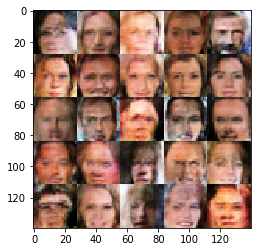

Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.7535... TS: 2017-08-25 08:33:35.582656
Epoch 2/2... Discriminator Loss: 1.5490... Generator Loss: 1.0961... TS: 2017-08-25 08:33:50.773472
Epoch 2/2... Discriminator Loss: 1.3513... Generator Loss: 0.7440... TS: 2017-08-25 08:34:05.904485
Epoch 2/2... Discriminator Loss: 1.3962... Generator Loss: 0.7285... TS: 2017-08-25 08:34:20.655795
Epoch 2/2... Discriminator Loss: 1.3788... Generator Loss: 0.7345... TS: 2017-08-25 08:34:36.096767


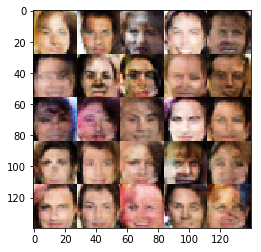

Epoch 2/2... Discriminator Loss: 1.3735... Generator Loss: 0.7855... TS: 2017-08-25 08:34:51.669310
Epoch 2/2... Discriminator Loss: 1.3353... Generator Loss: 0.8122... TS: 2017-08-25 08:35:06.910085
Epoch 2/2... Discriminator Loss: 1.3327... Generator Loss: 0.7747... TS: 2017-08-25 08:35:21.750523
Epoch 2/2... Discriminator Loss: 1.3657... Generator Loss: 0.8019... TS: 2017-08-25 08:35:36.874968
Epoch 2/2... Discriminator Loss: 1.3493... Generator Loss: 0.7957... TS: 2017-08-25 08:35:52.059320


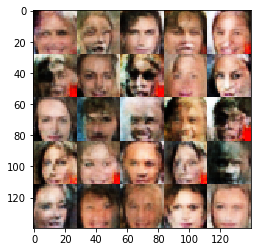

Epoch 2/2... Discriminator Loss: 1.3738... Generator Loss: 0.8020... TS: 2017-08-25 08:36:07.727028
Epoch 2/2... Discriminator Loss: 1.5248... Generator Loss: 0.9488... TS: 2017-08-25 08:36:22.927842
Epoch 2/2... Discriminator Loss: 1.3973... Generator Loss: 0.7801... TS: 2017-08-25 08:36:37.770320
Epoch 2/2... Discriminator Loss: 1.3851... Generator Loss: 0.7827... TS: 2017-08-25 08:36:52.871950
Epoch 2/2... Discriminator Loss: 1.4029... Generator Loss: 0.8909... TS: 2017-08-25 08:37:08.643030


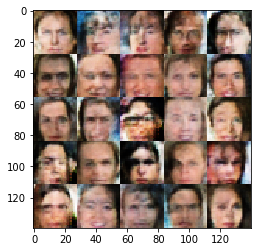

Epoch 2/2... Discriminator Loss: 1.4118... Generator Loss: 0.7858... TS: 2017-08-25 08:37:24.232048
Epoch 2/2... Discriminator Loss: 1.3933... Generator Loss: 0.8105... TS: 2017-08-25 08:37:39.743026
Epoch 2/2... Discriminator Loss: 1.4282... Generator Loss: 0.8204... TS: 2017-08-25 08:37:54.989186
Epoch 2/2... Discriminator Loss: 1.3531... Generator Loss: 0.7951... TS: 2017-08-25 08:38:10.449262
Epoch 2/2... Discriminator Loss: 1.4140... Generator Loss: 0.8627... TS: 2017-08-25 08:38:25.803566


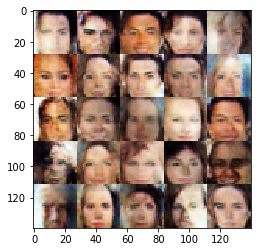

Epoch 2/2... Discriminator Loss: 1.3700... Generator Loss: 0.8471... TS: 2017-08-25 08:38:41.624395
Epoch 2/2... Discriminator Loss: 1.3075... Generator Loss: 0.8601... TS: 2017-08-25 08:38:56.773119
Epoch 2/2... Discriminator Loss: 1.3468... Generator Loss: 0.7882... TS: 2017-08-25 08:39:12.343517
Epoch 2/2... Discriminator Loss: 1.4090... Generator Loss: 0.7779... TS: 2017-08-25 08:39:27.139891
Epoch 2/2... Discriminator Loss: 1.3481... Generator Loss: 0.7897... TS: 2017-08-25 08:39:42.351002


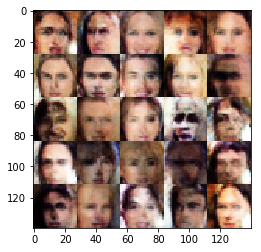

Epoch 2/2... Discriminator Loss: 1.3573... Generator Loss: 0.8713... TS: 2017-08-25 08:39:58.010666
Epoch 2/2... Discriminator Loss: 1.3720... Generator Loss: 0.8518... TS: 2017-08-25 08:40:13.021717
Epoch 2/2... Discriminator Loss: 1.4197... Generator Loss: 0.7842... TS: 2017-08-25 08:40:27.805844
Epoch 2/2... Discriminator Loss: 1.3542... Generator Loss: 0.8140... TS: 2017-08-25 08:40:42.735596
Epoch 2/2... Discriminator Loss: 1.3650... Generator Loss: 0.7964... TS: 2017-08-25 08:40:57.425907


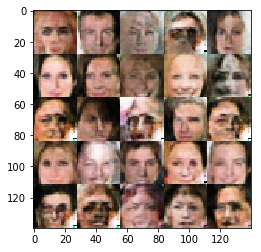

Epoch 2/2... Discriminator Loss: 1.3439... Generator Loss: 0.7668... TS: 2017-08-25 08:41:13.653856
Epoch 2/2... Discriminator Loss: 1.3908... Generator Loss: 0.8305... TS: 2017-08-25 08:41:28.770821
Epoch 2/2... Discriminator Loss: 1.3359... Generator Loss: 0.8228... TS: 2017-08-25 08:41:44.350138
Epoch 2/2... Discriminator Loss: 1.4064... Generator Loss: 0.7473... TS: 2017-08-25 08:41:59.265510
Epoch 2/2... Discriminator Loss: 1.3795... Generator Loss: 0.7667... TS: 2017-08-25 08:42:14.190091


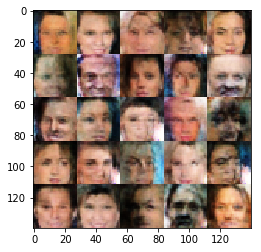

Epoch 2/2... Discriminator Loss: 1.3626... Generator Loss: 0.8557... TS: 2017-08-25 08:42:30.090621
Epoch 2/2... Discriminator Loss: 1.4835... Generator Loss: 0.8658... TS: 2017-08-25 08:42:45.107062
Epoch 2/2... Discriminator Loss: 1.3843... Generator Loss: 0.8076... TS: 2017-08-25 08:43:00.240402
Epoch 2/2... Discriminator Loss: 1.3792... Generator Loss: 0.8245... TS: 2017-08-25 08:43:15.330203
Epoch 2/2... Discriminator Loss: 1.4073... Generator Loss: 0.7624... TS: 2017-08-25 08:43:30.560314


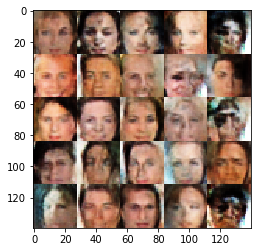

Epoch 2/2... Discriminator Loss: 1.3914... Generator Loss: 0.7462... TS: 2017-08-25 08:43:46.532577
Epoch 2/2... Discriminator Loss: 1.4230... Generator Loss: 0.7588... TS: 2017-08-25 08:44:01.423435
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.7256... TS: 2017-08-25 08:44:17.096535
Epoch 2/2... Discriminator Loss: 1.3816... Generator Loss: 0.8100... TS: 2017-08-25 08:44:31.745506
Epoch 2/2... Discriminator Loss: 1.4009... Generator Loss: 0.7940... TS: 2017-08-25 08:44:46.659676


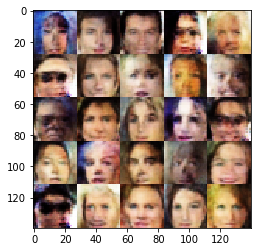

Epoch 2/2... Discriminator Loss: 1.4108... Generator Loss: 0.7720... TS: 2017-08-25 08:45:02.680253
Epoch 2/2... Discriminator Loss: 1.4001... Generator Loss: 0.7637... TS: 2017-08-25 08:45:17.882084
Epoch 2/2... Discriminator Loss: 1.4451... Generator Loss: 0.7965... TS: 2017-08-25 08:45:32.873343
Epoch 2/2... Discriminator Loss: 1.4010... Generator Loss: 0.8004... TS: 2017-08-25 08:46:06.435625
Epoch 2/2... Discriminator Loss: 1.3716... Generator Loss: 0.7788... TS: 2017-08-25 08:46:45.565587


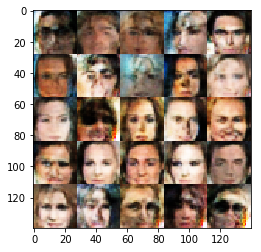

Epoch 2/2... Discriminator Loss: 1.3847... Generator Loss: 0.7975... TS: 2017-08-25 08:47:20.689861
Epoch 2/2... Discriminator Loss: 1.3509... Generator Loss: 0.8000... TS: 2017-08-25 08:48:02.360406
Epoch 2/2... Discriminator Loss: 1.3697... Generator Loss: 0.7585... TS: 2017-08-25 08:48:41.630327
Epoch 2/2... Discriminator Loss: 1.4454... Generator Loss: 0.6937... TS: 2017-08-25 08:49:16.243163
Epoch 2/2... Discriminator Loss: 1.3714... Generator Loss: 0.8417... TS: 2017-08-25 08:49:52.335281


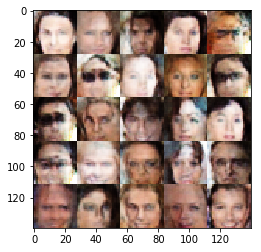

Epoch 2/2... Discriminator Loss: 1.4156... Generator Loss: 0.7422... TS: 2017-08-25 08:50:24.032361
Epoch 2/2... Discriminator Loss: 1.3790... Generator Loss: 0.8200... TS: 2017-08-25 08:50:39.059097
Epoch 2/2... Discriminator Loss: 1.3570... Generator Loss: 0.7983... TS: 2017-08-25 08:50:54.945417
Epoch 2/2... Discriminator Loss: 1.3545... Generator Loss: 0.7557... TS: 2017-08-25 08:51:09.959291
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.7873... TS: 2017-08-25 08:51:24.937239


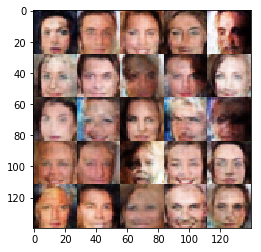

Epoch 2/2... Discriminator Loss: 1.3940... Generator Loss: 0.8642... TS: 2017-08-25 08:51:40.305008


In [ ]:
# Hyper parameters base on https://arxiv.org/pdf/1511.06434.pdf
batch_size = 64
z_dim = 128
learning_rate = 0.0003
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.